<a href="https://colab.research.google.com/github/ImagingDataCommons/IDC-Tutorials/blob/master/notebooks/getting_started/part2_searching_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting started with IDC - Part 2: Basics of searching IDC data

---

## Summary

This notebook is part of [the "Getting started with IDC" notebook series](https://github.com/ImagingDataCommons/IDC-Examples/blob/master/notebooks/getting_started) introducing NCI Imaging Data Commons to the users who want to interact with IDC programmatically.

In [Part 1](https://github.com/ImagingDataCommons/IDC-Examples/blob/master/notebooks/getting_started/part1_prerequisites.ipynb) of this tutorial series, you learned how to complete the prerequisites that are required to be able to search IDC data. If you have not completed Part 1, it's ok - this notebook is self-contained, and you don't need to go back to Part 1! This notebook continues at the beginner level, guiding you with how to use [`idc-index`](https://github.com/ImagingDataCommons/idc-index), a python package that aims to simplify access to the data available from NCI Imaging Data Commons.

Upon completion of this tutorial, you will learn:
* how to download images from IDC
* how to load and view DICOM images available from IDC
* what metadata attributes are available for filtering and how to filter data programmatically
* how to better leverage IDC visualization capabilities by programmatically generating viewer URLs for selected items, and embedding the viewer in your notebook
* how get the licensing information for the individual files, and how to comply with the attribution usage requirement, which is in place for most of the data in IDC

---
Initial version: Nov 2022

Updated: Nov 2024


## Warnings: read these to avoid errors!

In order to avoid errors, please keep in mind the following warnings:

1. **Execute each cell of the notebook in order without skipping** any code cells - otherwise you will likely encounter runtime errors!
2. If you are going through this notebook for the first time, **do not change any code until you successfully completed the notebook** (unless you are specifically asked to change something). Otherwise you may run into errors.



## Prerequisites

This tutorial relies on [`idc-index`](https://github.com/ImagingDataCommons/idc-index) - a python package that accompanies IDC and provides basic functionality around searching and accessing data from IDC.

We will install `idc-index` using `pip`. This package is under active development, and so we will use the `--upgrade` option to access the latest version. It should take around 1-2 minutes to install the dependencies and complete the next cell.

In [1]:
%%capture
!pip install idc-index --upgrade

## Downloading data from IDC

One of the first questions we get from the users of IDC is "How do I download the images?"

With `idc-index`, answering this question is easy.

We will head out to IDC Portal, that provides a basic interface to explore the data available in IDC. As you move around the IDC Portal explore page, you will be able to copy identifiers corresponding to the content available in IDC at the different levels of data hierarchy - starting from entire collections, down to the individual image series.

Try this out yourself! Open the IDC Portal explore page [https://portal.imaging.datacommons.cancer.gov/explore/](https://portal.imaging.datacommons.cancer.gov/explore/) in a separate window, and experiment with copying these identifiers. Identifiers for collections and patients/cases will be short strings, while unique identifiers for studies and series will be rather long strings of text that contain numbers and "." characters).

![IDC Portal demo](https://github.com/ImagingDataCommons/IDC-Tutorials/releases/download/0.2.0/Tutorial-copy.gif)

The identifier you have in the clipboard, is all you need to access the corresponding images. To download those, we will first instantiate `IDCClient` that is provided by `idc-index`.

In [2]:
from idc_index import IDCClient

idc_client = IDCClient()

In the following cell, we pass the identifier of a study to the function `download_from_selection()` to fetch the corresponding files. For the sake of the tutorial, please proceed with the identifier used in the following cell. You can experiment with using the identifiers you copied from the portal after you completed the notebook.


In [3]:
studyInstanceUID = "1.2.840.113654.2.55.68425808326883186792123057288612355322"


idc_client.download_from_selection(studyInstanceUID=studyInstanceUID, downloadDir=".")

# You can experiment with downloading all of the data for a patient by its PatientID, or for entire collections
# by uncommenting the lines below!
#idc_client.download_from_selection(patientId="LUNG1-025", downloadDir=".")
#idc_client.download_from_selection(collection_id="ct_phantom4radiomics", downloadDir=".")


You also have the choice of downloading from IDC using command-line helper tool that is installed as part of the `idc-index` package. The cell below shows how to download that same study from the command line.

In [4]:
!idc download 1.2.840.113654.2.55.68425808326883186792123057288612355322 --download-dir .

2024-11-28 17:08:47,168 - Downloading from IDC v20 index
2024-11-28 17:08:47,346 - Identified matching StudyInstanceUID: ['1.2.840.113654.2.55.68425808326883186792123057288612355322']
2024-11-28 17:08:47,415 - Total free space on disk: 206.840569856 GB
2024-11-28 17:08:47,666 - Not using s5cmd sync as the destination folder is empty or sync or progress bar is not requested
2024-11-28 17:08:47,677 - Initial size of the directory: 66.35 MB
2024-11-28 17:08:47,680 - Approximate size of the files that need to be downloaded: 314.45 MB
2024-11-28 17:08:52,956 - Successfully downloaded files to /content


Once the download is completed, you can check the current directory to examine the content. Note that files are downloaded in to a folder hierarchy to make navigation easier. The default hierarchy is `collection_id` > `PatientID` > `StudyInstanceUID` > `Modality`_`SeriesInstanceUID`, and the files you downloaded should be organized as shown below.

```
├── nlst   <--- collection ID
│   └── 100002   <--- Patient ID
│       └── 1.2.840.113654.2.55.68425808326883186792123057288612355322   <--- Study ID
│           ├── CT_1.2.840.113654.2.55.229650531101716203536241646069123704792   <--- Series ID
│           │   ├── 0025b198-6198-4b33-85cf-92582531ad28.dcm   <--- individual instances/files the series
│           │   ├── 00a93dcb-4cd0-46ca-ae41-9240421cb0c7.dcm        (corresponding to slices in radiology and
│           │   ├── 00aa5957-1b4e-4b8b-879f-c505e12f2dcc.dcm         resolution layers in digital pathology)
│           │   ├── 02da9050-622c-4e00-a0d4-a70dd418973c.dcm
...
```

The DICOM study we downloaded is from the National Lung Screening Trial (NLST) collection available in IDC. This study contains two Computed Tomography (CT) DICOM series, two DICOM Segmentations (SEG) with the results of segmenting the CT series using [TotalSegmentator](https://github.com/wasserth/TotalSegmentator), and 4 DICOM Structured Reporting series with the radiomics features extracted from the segmented images. Most of the CT images in the NLST collection in IDC are accompanied by TotalSegmentator segmentations and corresponding radiomics features!

## Loading and visualizing IDC DICOM images and segmentations

In this tutorial we will focus on visualization of radiology images.

Images available from IDC are stored using DICOM format. This is the format that is used virtually for all of the images produced by radiological medical imaging equipment. It is also increasingly adopted by the manufacturers of the digital pathology equipment.

DICOM format is supported by many open source tools and libraries. In the following cells we will use:
* [ITK](https://itk.org/) for loading DICOM images
* [pydicom-seg]() for loading DICOM segmentations
* and [itkWidgets](https://itkwidgets.readthedocs.io/en/latest/) for visualization.

In the following cell, which should take about a minute to complete, we will install these prerequisites. You may see some errors about incompatible packages in the end of the installation. Those should be harmless.

In [5]:
# Install the packages required for sorting and loading the data as well as visualization
!pip install -q "pydicom<3.0.0" pydicom-seg "itk-io>=5.3.0" "itkwidgets[all]>=1.0a32"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 55.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.6/152.6 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.9/179.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/2

Next we will import the necessary packages, and will load the CT image from the folder with the files we downloaded earlier.

In [7]:
import itk
from itkwidgets import view
# Pydicom-Seg is a layer on top of pydicom that handles DICOM SEG objects.
import pydicom
import pydicom_seg
import numpy as np

In [8]:
ct_image_path = "./nlst/100002/1.2.840.113654.2.55.68425808326883186792123057288612355322/CT_1.2.840.113654.2.55.229650531101716203536241646069123704792"

ct_image = itk.imread(ct_image_path)

We can next print the details about the loaded image. If the size of the image you loaded shows up as [512, 512, 126], then everything worked as expected!

In [9]:
print(ct_image)

Image (0x587603d04560)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 25563
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 222
  UpdateMTime: 25562
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 126]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 126]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 126]
  Spacing: [0.703125, 0.703125, 2.5]
  Origin: [-169.6, -180, -301.545]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.703125 0 0
0 0.703125 0
0 0 2.5

  PointToIndexMatrix: 
1.42222 0 0
0 1.42222 0
0 0 0.4

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x5876081c1830)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
     

Next we will load DICOM SEG series included in the study. We will use `pydicom-seg` library to load the segmentation as an array, which will then convert into ITK image, and resample to the CT image we loaded earlier.

In [10]:
# Read the DICOM SEG object using pydicom and pydicom_seg.
seg_image_path = "./nlst/100002/1.2.840.113654.2.55.68425808326883186792123057288612355322/SEG_1.2.276.0.7230010.3.1.3.313263360.15851.1706325185.577017/9629abf6-d1de-4931-bc6a-061890ae275c.dcm"
seg_dicom = pydicom.dcmread(seg_image_path)
seg_reader = pydicom_seg.MultiClassReader()
seg_obj = seg_reader.read(seg_dicom)

# Convert the DICOM SEG object into an itk image, with correct voxel origin, spacing, and directions in physical space.
seg_image = itk.image_from_array(seg_obj.data.astype(np.float32))
seg_image.SetOrigin(seg_obj.origin)
seg_image.SetSpacing(seg_obj.spacing)
seg_image.SetDirection(seg_obj.direction)
interpolator = itk.NearestNeighborInterpolateImageFunction.New(seg_image)
seg_image = itk.resample_image_filter(Input=seg_image,
                                            Interpolator=interpolator,
                                            reference_image=ct_image,
                                            use_reference_image=True)

Now that we have both the CT image and the SEG image loaded as ITK images, we can visualize them using itkWidgets `view()` function.

Note that the following cell may take about a minute to complete. Once the cell execution is done, you will need to wait a bit longer for the visualization widget to populate in the output cell, and a bit longer again (up to several minutes) for the image to properly render. While everything is being loaded, you will see a spinning icon next to the word "Image" in the upper left corner of the widget to indicate the content is being processed.

**Please be patient!** Until the image is fully processed by the widget, visualization may not show up correctly. The image below shows how the viewer should look like after everything loaded correctly.

<img src="https://github.com/ImagingDataCommons/IDC-Tutorials/releases/download/0.2.0/itkwidgets_demo.gif" alt="select" width="800"/>


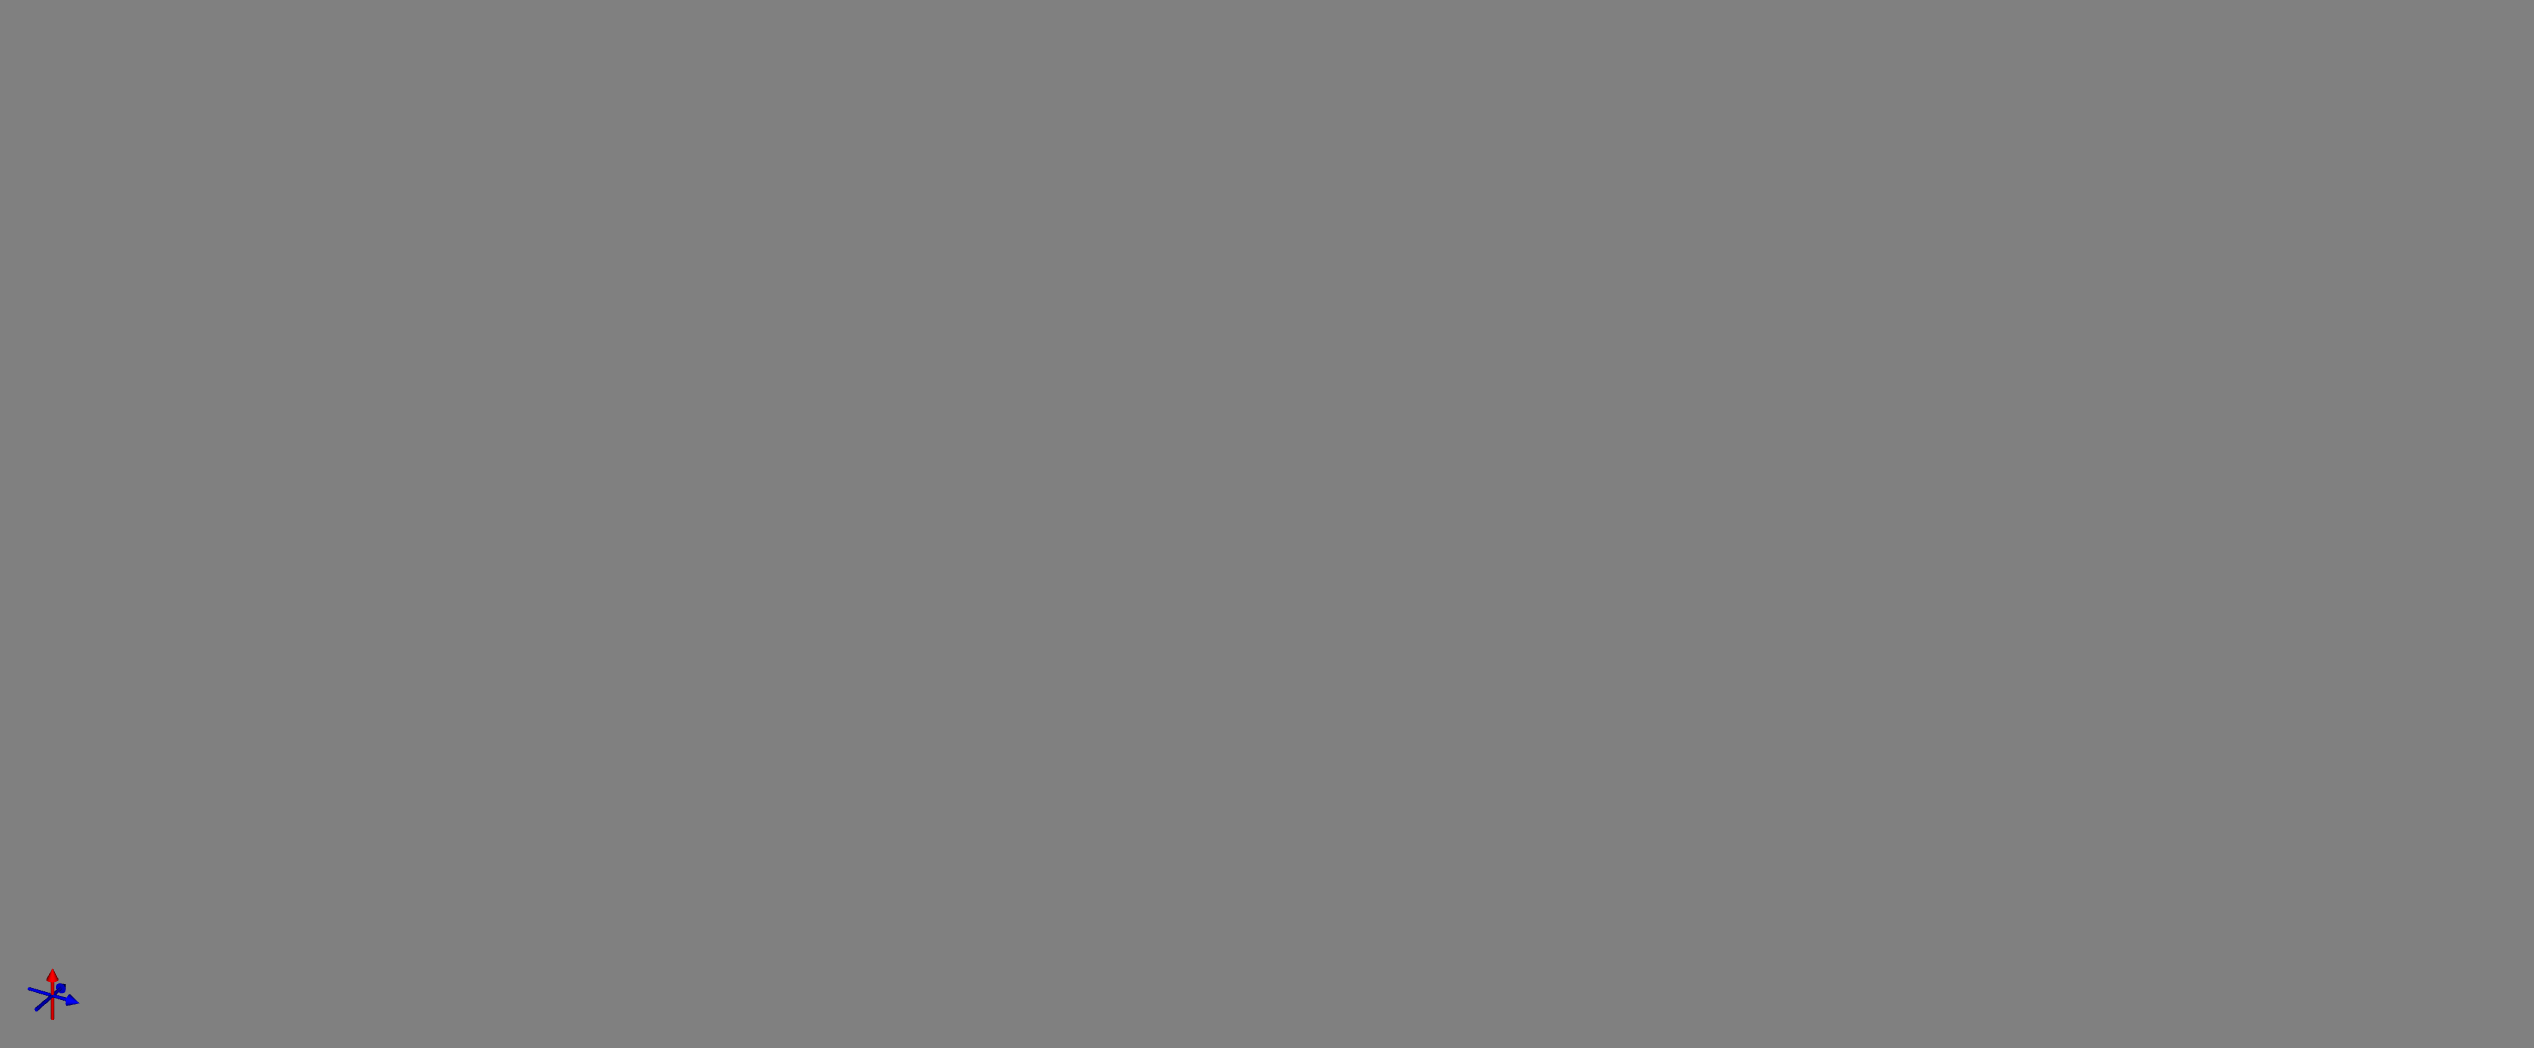
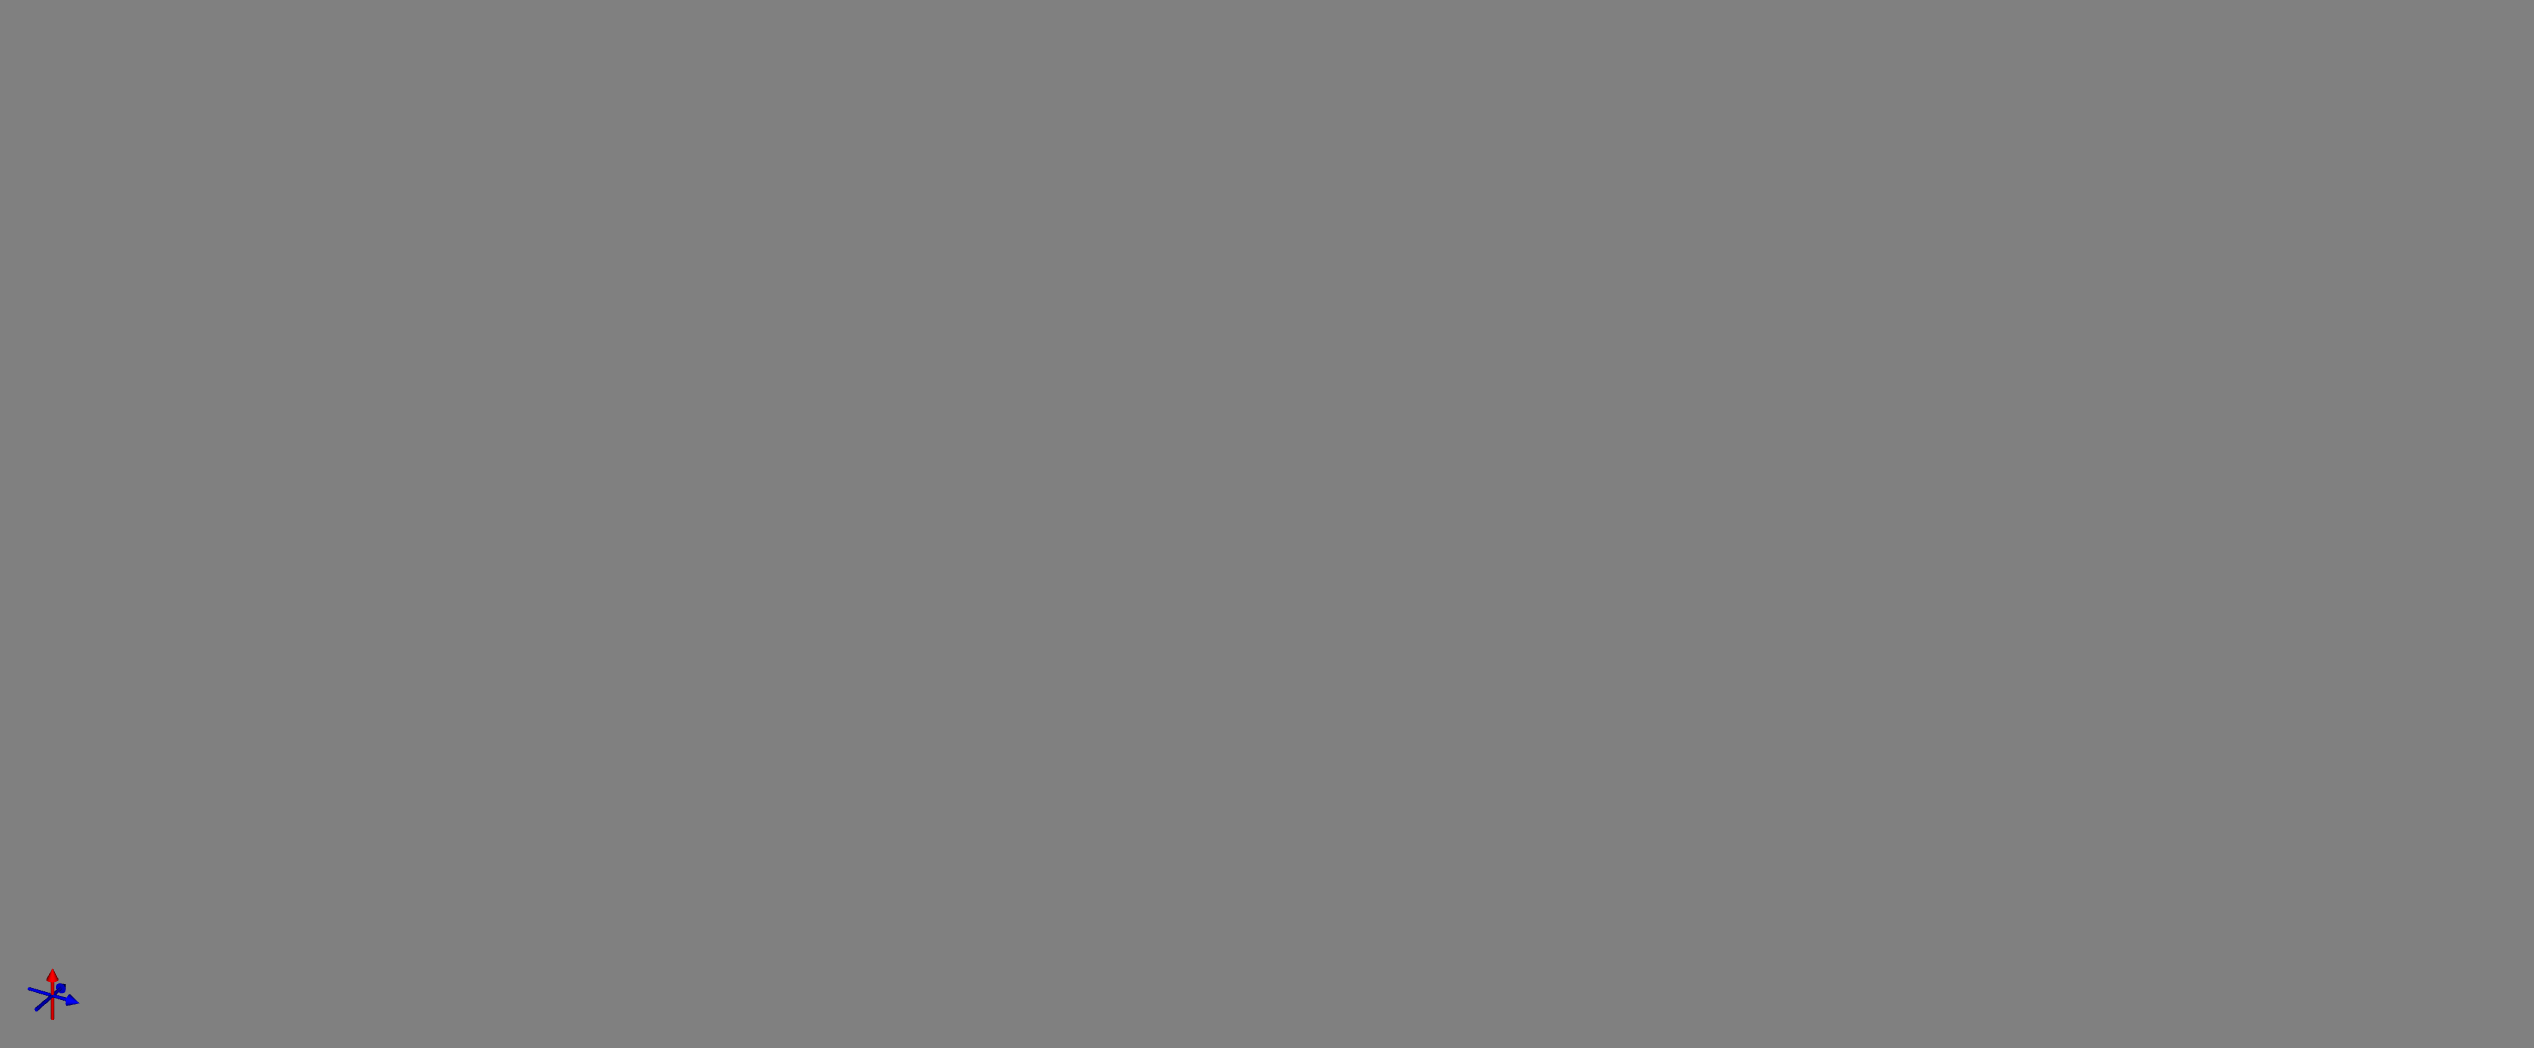

In [11]:
viewer = view(ct_image, label_image=seg_image, ui_collapsed=False)


As you can see, IDC data is easy to load and visualize using popular open source libraries!

## Searching IDC data

In the previous exercise, we identified the data by navigating the IDC Portal. IDC Portal can be very helpful if you want to browse through the data, quickly check out individual images, or get an idea about what is available.

You can also filter IDC data and explore what is available programmatically: `idc-index` to the rescue!

`idc-index` is named this way because it wraps _index_ of IDC data: a table containing most important metadata attributes describing the files available in IDC. This metadata index is available in the `index` variable (which is a pandas `DataFrame`) of `IDCClient`, which contains the following columns.




In [12]:
print(idc_client.index.columns.values)

['collection_id' 'analysis_result_id' 'PatientID' 'SeriesInstanceUID'
 'StudyInstanceUID' 'source_DOI' 'PatientAge' 'PatientSex' 'StudyDate'
 'StudyDescription' 'BodyPartExamined' 'Modality' 'Manufacturer'
 'ManufacturerModelName' 'SeriesDate' 'SeriesDescription' 'SeriesNumber'
 'instanceCount' 'license_short_name' 'series_aws_url' 'series_size_MB'
 'crdc_series_uuid']


We will discuss just a few of those columns - you can learn about those not discussed in [this `idc-index` documentation page](https://idc-index.readthedocs.io/en/latest/column_descriptions.html).

IDC is using DICOM for data representation, and in the DICOM data model, patients (identified by **`PatientID`** column) undergo imaging exams (or _studies_, in DICOM nomenclature).

Each patient will have one or more studies, with each study identified uniquely by the attribute **`StudyInstanceUID`**. During each of the imaging studies one or more imaging _series_ will be collected. As an example, a Computed Tomography (CT) imaging study may include a volume sweep before and after administration of the contrast agent. Imaging series are uniqiely identified by **`SeriesInstanceUID`**.

Individual collections within IDC group patients/cases, and are recognized by their **`collection_id`** values.

The function we used earlier - `download_from_selection()` - can be used to download images given any of these identifiers: `collection_id`,
`PatientID`, `StudyInstanceUID`, or `SeriesInstanceUID`.

In [13]:
help(idc_client.download_from_selection)

Help on method download_from_selection in module idc_index.index:

download_from_selection(downloadDir, dry_run=False, collection_id=None, patientId=None, studyInstanceUID=None, seriesInstanceUID=None, sopInstanceUID=None, crdc_series_uuid=None, quiet=True, show_progress_bar=True, use_s5cmd_sync=False, dirTemplate='%collection_id/%PatientID/%StudyInstanceUID/%Modality_%SeriesInstanceUID') method of idc_index.index.IDCClient instance
    Download the files corresponding to the selection. The filtering will be applied in sequence (but does it matter?) by first selecting the collection(s), followed by
    patient(s), study(studies) and series. If no filtering is applied, all the files will be downloaded.
    
    Args:
        downloadDir: string containing the path to the directory to download the files to
        dry_run: calculates the size of the cohort but download does not start
        collection_id: string or list of strings containing the values of collection_id to filter by
    

Any of the columns included in the index can be used to build filters, or selection queries, subsetting content that meets specific requirements.

For any of the index column, we can check the unique values for each column, to first understand what is available.

As an example, let's look at the `Modality` column, which contains an abbreviation encoding the type of image.

In [14]:
print(idc_client.index['Modality'].unique())

['CT' 'PT' 'MR' 'SM' 'DX' 'SEG' 'SR' 'MG' 'RTSTRUCT' 'M3D' 'CR' 'RTPLAN'
 'US' 'PR' 'RTDOSE' 'NM' 'XA' 'KO' 'REG' 'SC' 'RWV' 'XC' 'FUSION' 'OT'
 'RF' 'ANN']


As an exercise of using the index to subset IDC data, we will search for all Magnetic Resonance series. This can be done using the `Modality` column we used above. If you want to know what each of the abbreviations above stands for, check out this page from the DICOM standard: https://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.7.3.html#sect_C.7.3.1.1.1. But of the sake of this exercise, "MR" value corresponds to "Magnetic Resonance".

`index` is just a pandas `DataFrame`, and you can use pandas syntax to do the selection, as shown in the next cell.

In [15]:
mr_selection_pd = idc_client.index[idc_client.index['Modality'] == "MR"]

As an alternative, you can use Standard Query Language (SQL). The following cell accomplishes the same task using an SQL query.

In [16]:
query = """
SELECT *
FROM index
WHERE Modality = 'MR'
"""

mr_selection_sql = idc_client.sql_query(query)

In both cases, the result will be returned as a pandas `DataFrame` containing rows that have "Modality" set to "MR". You can see that in both cases, there are 122707 series that meet this selection criteria.

In [17]:
mr_selection_sql

Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.


,collection_id,analysis_result_id,PatientID,SeriesInstanceUID,StudyInstanceUID,source_DOI,PatientAge,PatientSex,StudyDate,StudyDescription,...,Manufacturer,ManufacturerModelName,SeriesDate,SeriesDescription,SeriesNumber,instanceCount,license_short_name,series_aws_url,series_size_MB,crdc_series_uuid
0,pdmr_292921_168_r,None,292921-168-R-1415,2.25.52562508346911983761523927257987425894,2.25.208756230218968583908466437463380881762,10.7937/tcia.2020.pcak-8z10,None,M,2019-03-20,NCI PDMR Tumor Characterization,...,Philips Medical Systems,Achieva,2019-03-20,TSE45 split,4013,36,CC BY 4.0,s3://idc-open-data/1461966c-1a43-4198-a664-921...,22.51,1461966c-1a43-4198-a664-9213ce671db1
1,upenn_gbm,None,UPENN-GBM-00073,1.3.6.1.4.1.14519.5.2.1.5542074552050843981810...,1.3.6.1.4.1.14519.5.2.1.2908533414156045303969...,10.7937/tcia.709x-dn49,068Y,M,2002-11-23,MRI BRAIN W/INJ/MHDI,...,SIEMENS,TrioTim,2002-11-23,ep2d_DTI_30dir,9,93,CC BY 4.0,s3://idc-open-data/b5ca88ab-bb87-4b53-9711-915...,110.12,b5ca88ab-bb87-4b53-9711-915d6b6541a1
2,upenn_gbm,None,UPENN-GBM-00393,1.3.6.1.4.1.14519.5.2.1.3194947574846003675214...,1.3.6.1.4.1.14519.5.2.1.2816649104808466125578...,10.7937/tcia.709x-dn49,069Y,F,2010-12-10,BRAIN^BRAIN,...,SIEMENS,TrioTim,2010-12-10,t1 axial stealth-post : Processed_CaPTk,24,192,CC BY 4.0,s3://idc-open-data/6eb21652-c127-4fa4-9561-82c...,25.75,6eb21652-c127-4fa4-9561-82cef589b458
3,breast_mri_nact_pilot,None,UCSF-BR-66,1.3.6.1.4.1.14519.5.2.1.7695.2311.961504369910...,1.3.6.1.4.1.14519.5.2.1.7695.2311.195372761058...,10.7937/k9/tcia.2016.qhsyhjky,048Y,F,1992-01-07,"MR BREAS, UNIT",...,GE MEDICAL SYSTEMS,GENESIS_SIGNA,1992-01-07,Dynamic-3dfgre: SER,31000,60,CC BY 3.0,s3://idc-open-data/fbbe6ce5-c9d7-4346-9d21-8bb...,8.23,fbbe6ce5-c9d7-4346-9d21-8bb9572170a1
4,upenn_gbm,None,UPENN-GBM-00398,1.3.6.1.4.1.14519.5.2.1.1321370275496387006647...,1.3.6.1.4.1.14519.5.2.1.7948613579489379867954...,10.7937/tcia.709x-dn49,069Y,M,2010-11-19,BRAIN^BRAIN,...,SIEMENS,TrioTim,2010-11-19,Axial T2 tse: Processed_CaPTk,3,64,CC BY 4.0,s3://idc-open-data/127fb2c9-ccaa-48ad-8c1f-7e3...,7.00,127fb2c9-ccaa-48ad-8c1f-7e38cc0e1e80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123157,ispy1,None,ISPY1_1045,1.3.6.1.4.1.14519.5.2.1.7695.1700.252777698659...,1.3.6.1.4.1.14519.5.2.1.7695.1700.118428709069...,10.7937/k9/tcia.2016.hdhpgjlk,049Y,F,1986-01-23,MRI BR UNILAT W&WO CONT LEFT,...,GE MEDICAL SYSTEMS,GENESIS_SIGNA,1986-01-23,T1 left breast post delay,7,52,CC BY 3.0,s3://idc-open-data/c944fe91-04c6-48a2-a60d-777...,7.08,c944fe91-04c6-48a2-a60d-777aecf8189d
123158,ispy1,None,ISPY1_1135,1.3.6.1.4.1.14519.5.2.1.7695.1700.615305979619...,1.3.6.1.4.1.14519.5.2.1.7695.1700.232588206214...,10.7937/k9/tcia.2016.hdhpgjlk,059Y,F,1987-08-02,MR BREASTUNI UE,...,GE MEDICAL SYSTEMS,GENESIS_SIGNA,1987-08-02,DWSSFSE Diffusion w fatsat,7,50,CC BY 3.0,s3://idc-open-data/92f2385f-a493-4541-9d06-a58...,6.77,92f2385f-a493-4541-9d06-a58c47ffc86f
123159,ispy1,None,ISPY1_1065,1.3.6.1.4.1.14519.5.2.1.7695.1700.154037209906...,1.3.6.1.4.1.14519.5.2.1.7695.1700.319023455610...,10.7937/k9/tcia.2016.hdhpgjlk,None,F,1986-04-10,MR BREAST WO/W CONT,...,Philips Medical Systems,Gyroscan Intera,1986-04-10,BRSTCA SENSFS3DSAG 6DYN: PE2,121002,70,CC BY 3.0,s3://idc-open-data/0ff2a54f-d42d-493a-b00f-993...,9.43,0ff2a54f-d42d-493a-b00f-993dd20d7457
123160,ispy1,None,ISPY1_1117,1.3.6.1.4.1.14519.5.2.1.7695.1700.121966219660...,1.3.6.1.4.1.14519.5.2.1.7695.1700.642706103327...,10.7937/k9/tcia.2016.hdhpgjlk,049Y,F,1986-11-08,MR BREASTUNI UE,...,GE MEDICAL SYSTEMS,GENESIS_SIGNA,None,PJN,648,11,CC BY 3.0,s3://idc-open-data/2336521a-c503-4576-9dc1-7bf...,5.81,2336521a-c503-4576-9dc1-7bf2ed032b32


As you search the data, you can combine multiple columns to build your cohort!

`BodyPartExamined` column describes the anatomy that was imaged. Similar to what we did to understand the values available in the `Modality` column, let's find the distinct values and this time also count the number of times that value is encountered.

In [18]:
sorted_unique_values = idc_client.index['BodyPartExamined'].value_counts().sort_values(ascending=False)

print(sorted_unique_values)

BodyPartExamined
CHEST               352806
BREAST              100341
PROSTATE             22984
LUNG                 10971
ABDOMEN               8893
PELVIS                5636
COLON                 3544
KIDNEY                3457
LIVER                 3267
BRAIN                 2013
HEADNECK              1448
HEAD                  1412
CHESTABDPELVIS        1153
EXTREMITY              934
BLADDER                846
OVARY                  844
UTERUS                 838
TSPINE                 641
CERVIX                 488
PANCREAS               428
PHANTOM                364
STOMACH                308
SKULL                  286
WHOLEBODY              268
ABDOMENPELVIS          230
MEDIASTINUM            180
SPINE                  131
ESOPHAGUS              126
ADRENAL                121
CSPINE                 102
LSPINE                  64
NECKCHESTABDPELV        63
CHESTABDOMEN            57
NECK                    45
RECTUM                  34
TLSPINE                 31
THYROID    

For the sake of example, let's filter images that meet two criteria: Magnetic Resonance (`MR`) as `Modality`, and `LIVER` as `BodyPartExamined`.

In [19]:
query = """
SELECT *
FROM index
WHERE Modality = 'MR' AND BodyPartExamined = 'LIVER'
"""

liver_mr_selection_sql = idc_client.sql_query(query)

In [20]:
liver_mr_selection_sql

Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.


,collection_id,analysis_result_id,PatientID,SeriesInstanceUID,StudyInstanceUID,source_DOI,PatientAge,PatientSex,StudyDate,StudyDescription,...,Manufacturer,ManufacturerModelName,SeriesDate,SeriesDescription,SeriesNumber,instanceCount,license_short_name,series_aws_url,series_size_MB,crdc_series_uuid
0,tcga_lihc,None,TCGA-BC-A10Y,1.3.6.1.4.1.14519.5.2.1.8421.4008.165737829269...,1.3.6.1.4.1.14519.5.2.1.8421.4008.253241154539...,10.7937/k9/tcia.2016.immqw8uq,076Y,M,1993-03-21,MRI ABD W+WO CONT,...,SIEMENS,Sonata,1993-03-21,Subtraction_S11_S9_1,14,88,CC BY 3.0,s3://idc-open-data/ed74a10a-60fe-4aa1-8c44-736...,34.86,ed74a10a-60fe-4aa1-8c44-736c0eab00a0
1,tcga_lihc,None,TCGA-DD-A4NJ,1.3.6.1.4.1.14519.5.2.1.3344.4008.345436872573...,1.3.6.1.4.1.14519.5.2.1.3344.4008.368700536079...,10.7937/k9/tcia.2016.immqw8uq,054Y,F,2004-03-30,MRI ABDOMEN W/WO CONTRAST (74183),...,SIEMENS,Avanto,2004-03-30,AX VIBE_Pre,12,88,CC BY 3.0,s3://idc-open-data/e61388db-859e-4b71-abd0-7e3...,34.86,e61388db-859e-4b71-abd0-7e310accb91f
2,tcga_lihc,None,TCGA-DD-A4NP,1.3.6.1.4.1.14519.5.2.1.3344.4008.185206193510...,1.3.6.1.4.1.14519.5.2.1.3344.4008.164794594228...,10.7937/k9/tcia.2016.immqw8uq,033Y,M,1999-01-21,*MRI - ABDOMEN,...,GE MEDICAL SYSTEMS,SIGNA EXCITE,1999-01-21,(lava arc) POST,10,348,CC BY 3.0,s3://idc-open-data/2ff18a3a-9390-4cc0-b083-7de...,184.43,2ff18a3a-9390-4cc0-b083-7de785b7ab18
3,tcga_lihc,None,TCGA-DD-A4NH,1.3.6.1.4.1.14519.5.2.1.3344.4008.233142894536...,1.3.6.1.4.1.14519.5.2.1.3344.4008.201829600838...,10.7937/k9/tcia.2016.immqw8uq,065Y,F,2004-06-13,MRI ABDOMEN W/WO CONTRAST (74183),...,SIEMENS,Avanto,2004-06-13,AX HASTE LONG TE,16,30,CC BY 3.0,s3://idc-open-data/095ae4d1-3c3d-4e58-9457-574...,3.04,095ae4d1-3c3d-4e58-9457-574da16b5286
4,tcga_lihc,None,TCGA-DD-A1EF,1.3.6.1.4.1.14519.5.2.1.3344.4008.260482159431...,1.3.6.1.4.1.14519.5.2.1.3344.4008.280574940552...,10.7937/k9/tcia.2016.immqw8uq,057Y,F,1999-12-01,MRI Abd wo&w,...,GE MEDICAL SYSTEMS,SIGNA EXCITE,1999-12-01,3 plane loc,1,63,CC BY 3.0,s3://idc-open-data/cb0165bb-d93e-4955-8020-dd6...,8.62,cb0165bb-d93e-4955-8020-dd6602590133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928,tcga_lihc,None,TCGA-DD-A4NF,1.3.6.1.4.1.14519.5.2.1.3344.4008.385090740780...,1.3.6.1.4.1.14519.5.2.1.3344.4008.308452142823...,10.7937/k9/tcia.2016.immqw8uq,071Y,M,2004-02-29,MRI LIVER ELASTOGRAPHY W/O,...,GE MEDICAL SYSTEMS,SIGNA EXCITE,2004-02-29,MRE,700,4,CC BY 3.0,s3://idc-open-data/cca5d478-50c0-4419-a006-9f5...,0.55,cca5d478-50c0-4419-a006-9f5d1220f421
929,tcga_lihc,None,TCGA-DD-A1EF,1.3.6.1.4.1.14519.5.2.1.3344.4008.307480562412...,1.3.6.1.4.1.14519.5.2.1.3344.4008.280574940552...,10.7937/k9/tcia.2016.immqw8uq,057Y,F,1999-12-01,MRI Abd wo&w,...,GE MEDICAL SYSTEMS,SIGNA EXCITE,1999-12-01,lava3d,7,336,CC BY 3.0,s3://idc-open-data/0939b7c7-9474-4ad9-845c-10b...,178.12,0939b7c7-9474-4ad9-845c-10bb4d9b5878
930,tcga_lihc,None,TCGA-BC-A5W4,1.3.6.1.4.1.14519.5.2.1.8421.4008.259154043948...,1.3.6.1.4.1.14519.5.2.1.8421.4008.121664577064...,10.7937/k9/tcia.2016.immqw8uq,070Y,M,2003-05-06,MRI ABD W WO CON,...,SIEMENS,Symphony,2003-05-06,VIBE_AXIAL_P,10,72,CC BY 3.0,s3://idc-open-data/ee7262e1-30f6-415e-91f7-bde...,11.28,ee7262e1-30f6-415e-91f7-bde02c78a7bf
931,tcga_lihc,None,TCGA-DD-A4NO,1.3.6.1.4.1.14519.5.2.1.3344.4008.171056092280...,1.3.6.1.4.1.14519.5.2.1.3344.4008.276936118755...,10.7937/k9/tcia.2016.immqw8uq,065Y,M,2000-03-11,MRI Abd wo&w,...,GE MEDICAL SYSTEMS,SIGNA HDx,2000-03-11,ax rt fse,5,40,CC BY 3.0,s3://idc-open-data/bc47dad7-da54-4153-8180-cd6...,21.22,bc47dad7-da54-4153-8180-cd67bf0f37ae


## Working with the search results

Now that we learned the basics of searching, we will go over some of the operations to apply to the search results. We will learn how to download your selection, how to visualize individual images, and how to learn about the terms of use and attribution - this will be important if you use images from IDC in publications or commercial work!

### Downloading selected images

Earlier we learned how to download the selected study, where study identifier was copied from the IDC Portal.

You can use the same function to download images that you found by searching the index. In the following cell we will use `SeriesInstanceUID` passed to the `download_from_selection()` function to download the first 10 series.

In [21]:
idc_client.download_from_selection(seriesInstanceUID = list(liver_mr_selection_sql['SeriesInstanceUID'].values[:10]), downloadDir=".")

### Visualizing selected images

To better understand the images available, you may want to take a look at them first. You do not need to leave the notebook to do that! `idc-index` provides a convenience function to generate a URL to open the viewer, and to even embed it in your notebook cell!

In the following cell we will pick a random row from the selection we did earlier, and generate the URL to open that image series in IDC-maintained image viewer.

In [24]:
import random

random_series = random.choice(liver_mr_selection_sql['SeriesInstanceUID'].values)
viewer_url = idc_client.get_viewer_URL(seriesInstanceUID=random_series, viewer_selector="ohif_v3")

print(viewer_url)

https://viewer.imaging.datacommons.cancer.gov/v3/viewer/?StudyInstanceUIDs=1.3.6.1.4.1.14519.5.2.1.8421.4008.303533339368406310446855637599&SeriesInstanceUIDs=1.3.6.1.4.1.14519.5.2.1.8421.4008.328010787802907923407541379931


In the following cell, we embed the viewer that opens the URL for the selected series into the output cell. This way you can examine items you selected without leaving the notebook page!

In [25]:
from IPython.display import IFrame
IFrame(viewer_url, width=1600, height=900)

### Getting license information for the selected images

Each of the files available from IDC is accompanied by a license that defines the terms of use. In most cases, those are generic, broadly accepted Creative Commons licenses.

The abbreviated license code is available in the `license_short_name` column. In the following cell we get the list of various licenses that are encountered across all of the selected series. You will see that the only license encountered is a Creative Commons By Attribution license https://creativecommons.org/licenses/by/3.0/deed.en, which does not restrict commercial use, but requires you to acknowledge the author if you reuse the item.

Most (>95%) of images in IDC are shared under the permissive CC-BY license that allows commercial use (but does require attribution)!

In [26]:
sorted_unique_values = liver_mr_selection_sql['license_short_name'].value_counts().sort_values(ascending=False)

print(sorted_unique_values)

license_short_name
CC BY 3.0    933
Name: count, dtype: int64


### Getting citation information

To get more details about how the data was collected you should use the `source_DOI` column, which contains Digital Object Identifier (DOI) for the dataset from where the given file originates.

We can easily access the complete list of DOIs that accompany the items in our selection.

In [27]:
sorted_unique_values = liver_mr_selection_sql['source_DOI'].value_counts().sort_values(ascending=False)

print(sorted_unique_values)

source_DOI
10.7937/k9/tcia.2016.immqw8uq    910
10.7937/k9/tcia.2018.oblamn27     23
Name: count, dtype: int64


If you use data from IDC, you should also acknowledge IDC as the source of the data, and cite individual datasets that you used.

To help you comply with the attribution requirements, `idc-index` provides a convenience function `citations_from_selection` that will look up the DOIs and generate the list of citations.

WARNING: As of May 30, 2024, due to server issues at api.crossref.org, the following cell may not work. In the future, we will replace the API call to CrossRef with a cached list of publication to address this issue.


In [28]:
idc_client.citations_from_selection(seriesInstanceUID=list(liver_mr_selection_sql['SeriesInstanceUID'].values))

['Erickson, B. J., Kirk, S., Lee, Y., Bathe, O., Kearns, M., Gerdes, C., Rieger-Christ, K., &amp; Lemmerman, J. (2016). <i>The Cancer Genome Atlas Liver Hepatocellular Carcinoma Collection (TCGA-LIHC)</i> (Version 5) [Data set]. The Cancer Imaging Archive. https://doi.org/10.7937/K9/TCIA.2016.IMMQW8UQ',
 'National Cancer Institute Clinical Proteomic Tumor Analysis Consortium (CPTAC). (2018). <i>The Clinical Proteomic Tumor Analysis Consortium Clear Cell Renal Cell Carcinoma Collection (CPTAC-CCRCC)</i> (Version 13) [Data set]. The Cancer Imaging Archive. https://doi.org/10.7937/K9/TCIA.2018.OBLAMN27',
 'Fedorov, A., Longabaugh, W. J. R., Pot, D., Clunie, D. A., Pieper, S. D., Gibbs, D. L., Bridge, C., Herrmann, M. D., Homeyer, A., Lewis, R., Aerts, H. J. W. L., Krishnaswamy, D., Thiriveedhi, V. K., Ciausu, C., Schacherer, D. P., Bontempi, D., Pihl, T., Wagner, U., Farahani, K., â\x80¦ Kikinis, R. (2023). National Cancer Institute Imaging Data Commons: Toward Transparency,              

You can also customize that citation list to be in BibTeX format (learn more in the documentation of the function here).

In [30]:
from idc_index import index
idc_client.citations_from_selection(seriesInstanceUID=list(liver_mr_selection_sql['SeriesInstanceUID'].values), citation_format=index.IDCClient.CITATION_FORMAT_BIBTEX)

['@misc{https://doi.org/10.7937/k9/tcia.2016.immqw8uq,\n  doi = {10.7937/K9/TCIA.2016.IMMQW8UQ},\n  url = {https://www.cancerimagingarchive.net/collection/tcga-lihc/},\n  author = {Erickson, Bradley J. and Kirk, Shanah and Lee, Yueh and Bathe, Oliver and Kearns, Melissa and Gerdes, Cindy and Rieger-Christ, Kimberly and Lemmerman, John},\n  title = {The Cancer Genome Atlas Liver Hepatocellular Carcinoma Collection (TCGA-LIHC)},\n  publisher = {The Cancer Imaging Archive},\n  year = {2016},\n  copyright = {Creative Commons Attribution 3.0 Unported}\n}\n',
 '@misc{https://doi.org/10.7937/k9/tcia.2018.oblamn27,\n  doi = {10.7937/K9/TCIA.2018.OBLAMN27},\n  url = {https://www.cancerimagingarchive.net/collection/cptac-ccrcc/},\n  author = {{National Cancer Institute Clinical Proteomic Tumor Analysis Consortium (CPTAC)}},\n  title = {The Clinical Proteomic Tumor Analysis Consortium Clear Cell Renal Cell Carcinoma Collection (CPTAC-CCRCC)},\n  publisher = {The Cancer Imaging Archive},\n  year =

## Summary

This is it! We hope you indeed learned how to search, visualize, and download images from IDC, and how to comply with the usage terms by understanding what license covers specific dataset, and how to attribute its authors.

We hope you enjoyed this tutorial! If you want to learn more about IDC, you can check out the [Getting Started documentation page](https://learn.canceridc.dev/getting-started-with-idc), or take a look at other tutorials we have in the [IDC-Tutorials GitHub repository](https://github.com/ImagingDataCommons/IDC-Tutorials/tree/master).

If something didn't work as expected, if you have any feedback or suggestions of what should be added to this tutorial, please contact IDC support by sending email to support@canceridc.dev or posting your question on [IDC User forum](https://discourse.canceridc.dev).

## Acknowledgments

Imaging Data Commons has been funded in whole or in part with Federal funds from the National Cancer Institute, National Institutes of Health, under Task Order No. HHSN26110071 under Contract No. HHSN261201500003l.

If you use IDC in your research, please cite the following publication:

> Fedorov, A., Longabaugh, W. J. R., Pot, D., Clunie, D. A., Pieper, S. D., Gibbs, D. L., Bridge, C., Herrmann, M. D., Homeyer, A., Lewis, R., Aerts, H. J. W., Krishnaswamy, D., Thiriveedhi, V. K., Ciausu, C., Schacherer, D. P., Bontempi, D., Pihl, T., Wagner, U., Farahani, K., Kim, E. & Kikinis, R. _National Cancer Institute Imaging Data Commons: Toward Transparency, Reproducibility, and Scalability in Imaging Artificial Intelligence_. RadioGraphics (2023). https://doi.org/10.1148/rg.230180